In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow.keras import layers
from tensorflow import keras
from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
#from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

In [2]:
# the code should work, but you have to preprocess the data by hand yourself: 
# MinMax Scaler should be  - please double check the formulas

# before training: 
scale_min = -1
scale_max = 1

def scaling(df,df_min,df_max,scale_min,scale_max):
    df_std = (df-df_min) / (df_max-df_min)
    df_scaled = df_std* (scale_max - scale_min)+scale_min
    return df_scaled
# when you use this, be careful to store the df_min, df_max values somewhere because you need them for the inversion

#reverse scaling
# after training for final comparison
def scaling_reverse(df,df_min,df_max,scale_min,scale_max):
    df_scaled_reverse = (df-scale_min)/(scale_max-scale_min)*(df_max-df_min)+df_min
    return df_scaled_reverse

In [3]:
# the training data file below should be the scaled version of the data
# for getting the good pretrained model, use your best hyperparameter set 

In [4]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
model_name = 'forward_model'

In [6]:
def load_dataset_wo_split(datafile):
    dvar_trainval = pd.read_hdf(datafile, key='dvar')
    qoi_trainval = pd.read_hdf(datafile, key='qoi')

    dvar_trainval.reset_index(drop=True, inplace=True)
    qoi_trainval.reset_index(drop=True, inplace=True)

    kf = KFold(n_splits=5, random_state=76, shuffle=True)

    train_ind, val_ind = next(kf.split(dvar_trainval))

    dvar_train = dvar_trainval.values[train_ind]
    dvar_val = dvar_trainval.values[val_ind]
    qoi_train = qoi_trainval.values[train_ind]
    qoi_val = qoi_trainval.values[val_ind]

    return dvar_train, dvar_val, qoi_train, qoi_val

In [7]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

# Input the Training data - change path

In [8]:
train_datafile = '/data/project/general/aerosolretriev/aerosol_data/data_MP/GO_Cut/DS20000_532nm_GO.h5'

dvar_train_wo_scaling, dvar_val_wo_scaling, qoi_train_wo_scaling, qoi_val_wo_scaling = load_dataset_wo_split(train_datafile)


#dvar_train, dvar_val, qoi_train, qoi_val = load_dataset_wo_split(train_datafile)

# Scale the training data
 - skip if already done in the input file

In [9]:
dvar_min = min(np.min(dvar_train_wo_scaling), np.min(dvar_val_wo_scaling))
dvar_max = max(np.max(dvar_train_wo_scaling),np.max(dvar_val_wo_scaling))

qoi_min = min(np.min(qoi_train_wo_scaling), np.min(qoi_val_wo_scaling))
qoi_max = max(np.max(qoi_train_wo_scaling),np.max(qoi_val_wo_scaling))

In [10]:
dvar_train = scaling(dvar_train_wo_scaling, dvar_min, dvar_max, scale_min, scale_max)
dvar_val = scaling(dvar_val_wo_scaling, dvar_min, dvar_max, scale_min, scale_max)

qoi_train = scaling(qoi_train_wo_scaling, qoi_min, qoi_max, scale_min, scale_max)
qoi_val = scaling(qoi_val_wo_scaling, qoi_min, qoi_max, scale_min, scale_max)

# Input the Model - change path

In [11]:
model_dir = '/data/project/general/aerosolretriev/aerosol_results_rb/results_data_MP/trial1_0/models'
model_dir_improved =  '/data/project/general/aerosolretriev/aerosol_results_rb/results_data_MP/trial1_0/models_improved/'

# Load the model


In [12]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs)


In [13]:
surr

In [14]:
surr.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 118)               18998     
_________________________________________________________________
dense_1 (Dense)              (None, 118)               14042     
_________________________________________________________________
dense_2 (Dense)              (None, 118)               14042     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 595       
Total params: 47,677
Trainable params: 47,677
Non-trainable params: 0
_________________________________________________________________


In [15]:
#n_out = qoi_train.shape[1]
#n_in  =dvar_train.shape[1]
#add_model = tf.keras.Input(n_in)
#add_model = surr.model(add_model)

#layers.append(tf.keras.layers.Dense(units=n_out))
#layers.append(tf.keras.layers.Dense(units=n_out))

#layers = tf.keras.layers.Dense(layers)
#layers = tf.keras.layers.Dense(layers)

#add_model.add(layers.Dense(n_out, activation="relu", name = 'add_dense_1'))
#add_model.add(layers.Dense(n_out, activation="relu", name = 'add_dense_2'))
#add_model.add(layers.Dense(n_out, name = 'add_dense_3'))


#model = tf.keras.models.Sequential(layers)


# Rename existing model

In [16]:
new_model = surr.model

In [17]:
weights_old = surr.model.get_weights()

In [18]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 118)               18998     
_________________________________________________________________
dense_1 (Dense)              (None, 118)               14042     
_________________________________________________________________
dense_2 (Dense)              (None, 118)               14042     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 595       
Total params: 47,677
Trainable params: 47,677
Non-trainable params: 0
_________________________________________________________________


In [19]:

n_in = dvar_train.shape[1]
opt = keras.optimizers.Adam(learning_rate=3.3e-05)

# Compile the model again

In [20]:
new_model.compile(loss = 'MSE',optimizer=opt,
                  metrics=['MAE', 'MAPE'])


In [21]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 118)               18998     
_________________________________________________________________
dense_1 (Dense)              (None, 118)               14042     
_________________________________________________________________
dense_2 (Dense)              (None, 118)               14042     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 595       
Total params: 47,677
Trainable params: 47,677
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [22]:
new_model.fit(dvar_train, qoi_train, validation_data = (dvar_val,qoi_val), batch_size =100, epochs = 100)

Epoch 1/100
160/160 [==============================] - 5s 23ms/step - loss: 62.2748 - MAE: 4.5932 - MAPE: 1059.6036 - val_loss: 5.9048 - val_MAE: 1.7563 - val_MAPE: 392.9452
Epoch 2/100
160/160 [==============================] - 2s 12ms/step - loss: 3.9947 - MAE: 1.4441 - MAPE: 317.8572 - val_loss: 1.2770 - val_MAE: 0.8347 - val_MAPE: 265.7402
Epoch 3/100
160/160 [==============================] - 2s 12ms/step - loss: 1.0472 - MAE: 0.7526 - MAPE: 426.4726 - val_loss: 0.5398 - val_MAE: 0.5465 - val_MAPE: 200.2585
Epoch 4/100
160/160 [==============================] - 2s 12ms/step - loss: 0.4499 - MAE: 0.4998 - MAPE: 189.5123 - val_loss: 0.2721 - val_MAE: 0.3810 - val_MAPE: 153.2503
Epoch 5/100
160/160 [==============================] - 2s 12ms/step - loss: 0.2383 - MAE: 0.3592 - MAPE: 150.3216 - val_loss: 0.1916 - val_MAE: 0.3134 - val_MAPE: 139.5005
Epoch 6/100
160/160 [==============================] - 2s 12ms/step - loss: 0.1751 - MAE: 0.3027 - MAPE: 214.8043 - val_loss: 0.1570 - val

160/160 [==============================] - 2s 12ms/step - loss: 0.0296 - MAE: 0.1095 - MAPE: 109.0650 - val_loss: 0.0302 - val_MAE: 0.1103 - val_MAPE: 83.0224
Epoch 49/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0297 - MAE: 0.1092 - MAPE: 128.4314 - val_loss: 0.0293 - val_MAE: 0.1083 - val_MAPE: 82.8851
Epoch 50/100
160/160 [==============================] - 2s 13ms/step - loss: 0.0285 - MAE: 0.1067 - MAPE: 88.1457 - val_loss: 0.0290 - val_MAE: 0.1078 - val_MAPE: 81.8926
Epoch 51/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0279 - MAE: 0.1060 - MAPE: 81.2773 - val_loss: 0.0288 - val_MAE: 0.1076 - val_MAPE: 83.0243
Epoch 52/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0274 - MAE: 0.1048 - MAPE: 94.8547 - val_loss: 0.0274 - val_MAE: 0.1038 - val_MAPE: 78.9699
Epoch 53/100
160/160 [==============================] - 2s 12ms/step - loss: 0.0266 - MAE: 0.1029 - MAPE: 81.3443 - val_loss: 0.0271 - val_MAE: 0.1044 - val

Epoch 96/100
160/160 [==============================] - 1s 9ms/step - loss: 0.0104 - MAE: 0.0614 - MAPE: 83.8505 - val_loss: 0.0107 - val_MAE: 0.0625 - val_MAPE: 57.8977
Epoch 97/100
160/160 [==============================] - 1s 9ms/step - loss: 0.0103 - MAE: 0.0613 - MAPE: 79.6049 - val_loss: 0.0102 - val_MAE: 0.0606 - val_MAPE: 56.7662
Epoch 98/100
160/160 [==============================] - 2s 10ms/step - loss: 0.0097 - MAE: 0.0599 - MAPE: 87.7919 - val_loss: 0.0101 - val_MAE: 0.0599 - val_MAPE: 54.0859
Epoch 99/100
160/160 [==============================] - 2s 9ms/step - loss: 0.0096 - MAE: 0.0596 - MAPE: 53.6629 - val_loss: 0.0099 - val_MAE: 0.0591 - val_MAPE: 55.5080
Epoch 100/100
160/160 [==============================] - 1s 9ms/step - loss: 0.0094 - MAE: 0.0591 - MAPE: 67.6936 - val_loss: 0.0099 - val_MAE: 0.0591 - val_MAPE: 55.3732


In [23]:
weights_new = new_model.get_weights()

# Save the model 

In [24]:
new_model.save(f'{model_dir_improved}forward_model')


INFO:tensorflow:Assets written to: /data/project/general/aerosolretriev/aerosol_results_rb/results_data_MP/trial1_0/models_improved/forward_model/assets


# Print training history

In [25]:
print(new_model.history.history.keys())

dict_keys(['loss', 'MAE', 'MAPE', 'val_loss', 'val_MAE', 'val_MAPE'])


In [26]:
loss = new_model.history.history['loss']
val_loss = new_model.history.history['val_loss']

Text(0.5, 0, 'epochs')

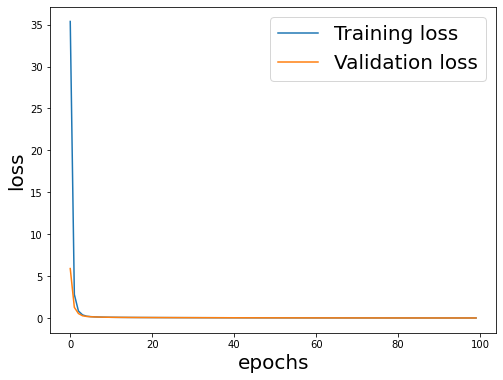

In [27]:
plt.figure(figsize = (8,6))
plt.plot(loss, label = 'Training loss')
plt.plot(val_loss, label = 'Validation loss')
plt.legend(fontsize = 20)
plt.ylabel('loss', fontsize = 20)
plt.xlabel('epochs', fontsize = 20)

In [28]:
new_model.history.history['loss']

[35.37960491478443,
 2.817261966317892,
 0.8394194960594177,
 0.3774311109445989,
 0.21833184594288468,
 0.1672268440015614,
 0.14014395456761122,
 0.12174093825742602,
 0.10875348416157067,
 0.0993198670912534,
 0.09218684718944133,
 0.08638757173903286,
 0.08161246883682907,
 0.07755638540256768,
 0.07409213241189719,
 0.07100992826744915,
 0.06824612086638808,
 0.06586058479733765,
 0.06372328735888004,
 0.06172660572919995,
 0.0599262819159776,
 0.05820878800004721,
 0.056547573092393576,
 0.05500903956126422,
 0.053419804712757465,
 0.05211846553720534,
 0.05073083627503365,
 0.04939218496438116,
 0.04813988171517849,
 0.0469175428384915,
 0.04573049134342,
 0.04458462954498828,
 0.04339857597369701,
 0.04228716359939426,
 0.041205318935681134,
 0.04023392188828438,
 0.03891134358709678,
 0.03791749476222321,
 0.036934077774640174,
 0.036019630800001326,
 0.035112721170298754,
 0.03424291810952127,
 0.0333922500256449,
 0.03265231163240969,
 0.03188099295366555,
 0.031115618487820

In [44]:
surr = KerasSurrogate.load(model_dir, model_name, model_kwargs=kwargs) #to be sure, that your old model was not overwritten 


In [45]:
qoi_predict_old = surr.model.predict(dvar_train)
qoi_predict_new = new_model.predict(dvar_train)
qoi_predict_old

array([[ -2.71879543,   5.34344747, -22.52327696,  -1.06294503,
          3.24415785],
       [  0.86758388,   3.37463397, -22.95032717,  -1.1036895 ,
          2.30651561],
       [ -0.24335286,   1.90427577, -24.200505  ,  -0.76156964,
          2.38782559],
       ...,
       [ -0.7780606 ,   1.21910505, -17.11078133,  -0.28154713,
          2.26162611],
       [ -0.26426814,   1.34651873, -22.94497234,  -1.30722313,
          1.52966266],
       [  1.83713903,   2.96196478, -26.48563628,  -2.36818104,
          1.08979962]])

In [46]:
qoi_predict_new

array([[-0.95905259, -0.96848205, -0.99607086, -0.92093024, -0.78312714],
       [-1.00003314, -1.02011718, -1.02151078, -0.60333843,  0.35193963],
       [-1.02418879, -1.04000518, -1.03356056, -0.67985116, -0.61125542],
       ...,
       [-1.022701  , -0.92039223, -0.96530255, -0.65788479,  0.4199636 ],
       [-1.04462894, -1.01927179, -1.0834087 , -0.13751575,  0.30070284],
       [-1.01491625, -0.998143  , -1.01420005, -0.17013519, -0.52219897]])

In [47]:
residual_old = qoi_train - qoi_predict_old
residual_new = qoi_train - qoi_predict_new

rel_error_old = np.abs(residual_old / qoi_train)
rel_error_new = np.abs(residual_new / qoi_train)

In [48]:
rel_error_old = pd.DataFrame(rel_error_old)
rel_error_old.mean()

0     1.456512
1     3.839125
2    22.308772
3    27.563178
4    17.224778
dtype: float64

In [49]:
rel_error_new = pd.DataFrame(rel_error_new)
rel_error_new.mean()

0    0.019821
1    0.016433
2    0.061505
3    2.163476
4    1.182009
dtype: float64

In [50]:
qoi_predict_old 

array([[ -2.71879543,   5.34344747, -22.52327696,  -1.06294503,
          3.24415785],
       [  0.86758388,   3.37463397, -22.95032717,  -1.1036895 ,
          2.30651561],
       [ -0.24335286,   1.90427577, -24.200505  ,  -0.76156964,
          2.38782559],
       ...,
       [ -0.7780606 ,   1.21910505, -17.11078133,  -0.28154713,
          2.26162611],
       [ -0.26426814,   1.34651873, -22.94497234,  -1.30722313,
          1.52966266],
       [  1.83713903,   2.96196478, -26.48563628,  -2.36818104,
          1.08979962]])

In [51]:
qoi_predict_new

array([[-0.95905259, -0.96848205, -0.99607086, -0.92093024, -0.78312714],
       [-1.00003314, -1.02011718, -1.02151078, -0.60333843,  0.35193963],
       [-1.02418879, -1.04000518, -1.03356056, -0.67985116, -0.61125542],
       ...,
       [-1.022701  , -0.92039223, -0.96530255, -0.65788479,  0.4199636 ],
       [-1.04462894, -1.01927179, -1.0834087 , -0.13751575,  0.30070284],
       [-1.01491625, -0.998143  , -1.01420005, -0.17013519, -0.52219897]])

In [52]:
qoi_train

array([[-0.99942321, -0.99992711, -0.99943116, -0.9229017 , -0.83191559],
       [-0.99936118, -0.99993392, -0.99942396, -0.62093438,  0.02616959],
       [-0.99940148, -0.99997037, -0.99942594, -0.73097006, -0.61159857],
       ...,
       [-0.99939068, -0.999987  , -0.99942235, -0.66579689,  0.40418909],
       [-0.99936812, -0.99999446, -0.99943667, -0.06232636,  0.28990841],
       [-0.99943976, -0.99992931, -0.99942628, -0.17257898, -0.5879388 ]])

In [61]:
qoi_train_wo_scaling

array([[1.44193761e+00, 1.82232294e-01, 1.42206011e+00, 1.92741208e+02,
        4.20201135e+02],
       [1.59701144e+00, 1.65208163e-01, 1.44006009e+00, 9.47641769e+02,
        2.56536363e+03],
       [1.49627868e+00, 7.40780728e-02, 1.43511487e+00, 6.72559041e+02,
        9.70980738e+02],
       ...,
       [1.52326047e+00, 3.25035112e-02, 1.44409723e+00, 8.35488123e+02,
        3.51039014e+03],
       [1.57965889e+00, 1.38597363e-02, 1.40829443e+00, 2.34412895e+03,
        3.22469515e+03],
       [1.40058415e+00, 1.76721720e-01, 1.43426880e+00, 2.06850387e+03,
        1.03012877e+03]])

In [58]:
qoi_predict_old_rescaled = scaling_reverse(qoi_predict_old,qoi_min,qoi_max,scale_min,scale_max)
qoi_predict_new_rescaled = scaling_reverse(qoi_predict_new,qoi_min,qoi_max,scale_min,scale_max)

In [59]:
qoi_predict_old_rescaled

array([[ -4296.88745976,  15858.24552079, -53806.9263102 ,
          -157.35886701,  10610.14497191],
       [  4668.84984386,  10936.32759446, -54874.52670562,
          -259.2176447 ,   8266.09451851],
       [  1891.57334736,   7260.51859158, -57999.89774274,
           596.06187172,   8469.36470301],
       ...,
       [   554.83543991,   5547.63207974, -40276.00560792,
          1796.0899174 ,   8153.87341029],
       [  1839.28637304,   5866.15879354, -54861.13993708,
          -768.03975093,   6324.00785905],
       [  7092.68069181,   9904.67888169, -63712.59150535,
         -3420.37210634,   5224.3761278 ]])

In [60]:
qoi_predict_new_rescaled

array([[ 1.02366131e+02,  7.87930266e+01,  9.82262215e+00,
         1.97669745e+02,  5.42169395e+02],
       [-8.28336648e-02, -5.02917498e+01, -5.37756836e+01,
         9.91630598e+02,  3.37976955e+03],
       [-6.04705358e+01, -1.00010597e+02, -8.38994261e+01,
         8.00353262e+02,  9.71838598e+02],
       ...,
       [-5.67511539e+01,  1.99014759e+02,  8.67415954e+01,
         8.55267910e+02,  3.54982547e+03],
       [-1.11569708e+02, -4.81783480e+01, -2.08516844e+02,
         2.15615989e+03,  3.25168059e+03],
       [-3.72897518e+01,  4.64240262e+00, -3.54992956e+01,
         2.07461321e+03,  1.19447447e+03]])

In [64]:
qoi_residual_old = qoi_train_wo_scaling - qoi_predict_old_rescaled
qoi_residual_new = qoi_train_wo_scaling - qoi_predict_new_rescaled

In [65]:
qoi_rel_error_old = np.abs(qoi_residual_old/qoi_train_wo_scaling)
qoi_rel_error_new = np.abs(qoi_residual_new/qoi_train_wo_scaling)


In [67]:
qoi_rel_error_old = pd.DataFrame(qoi_rel_error_old)
qoi_rel_error_new = pd.DataFrame(qoi_rel_error_new)


In [69]:
qoi_rel_error_old.mean()

0      2483.142443
1    327115.023966
2     39118.009404
3         1.712122
4        11.172781
dtype: float64

In [70]:
qoi_rel_error_new.mean()

0      33.919177
1    5508.253683
2     107.847914
3       0.154036
4       0.522783
dtype: float64

In [57]:
weights_old

[array([[ 0.14803119, -0.16169738,  0.11437482, ..., -0.13184475,
         -0.25905128, -0.08894926],
        [ 0.29141563, -0.26777852,  0.26529099, ..., -0.07441924,
         -0.10177943,  0.05606898],
        [ 0.24497676, -0.02007941,  0.13198094, ..., -0.10032337,
         -0.11860433, -0.02371374],
        ...,
        [ 0.02557175, -0.12769713, -0.01692146, ..., -0.10908897,
         -0.05246615, -0.04103097],
        [ 0.00242448, -0.09496291, -0.01598854, ...,  0.02063006,
         -0.14250854,  0.0870913 ],
        [-0.05952392, -0.13548128,  0.05942308, ...,  0.08990962,
         -0.0362936 ,  0.08635667]]),
 array([ 3.51996462e-02,  2.58628787e-02,  3.90356815e-01, -4.63058973e-03,
         1.40456644e-02,  2.38659436e-02,  1.45230599e-01,  3.45851206e-02,
         2.79721269e-02, -3.79729447e-03, -3.84466031e-03, -1.00401191e-01,
         3.85584178e-02, -2.47728436e-02, -4.53746923e-02, -4.15154312e-02,
         3.59755252e-02,  1.09765007e-01, -7.92462406e-02, -5.6278505

In [42]:
weights_new

[array([[ 0.14803119, -0.15980641,  0.13304033, ..., -0.14936334,
         -0.25516708, -0.07946666],
        [ 0.29141563, -0.26580396,  0.28383226, ..., -0.09530795,
         -0.09703323,  0.06570073],
        [ 0.24497676, -0.01722788,  0.14928539, ..., -0.12448628,
         -0.11359026, -0.01462568],
        ...,
        [ 0.02557175, -0.12934814, -0.03352668, ..., -0.10978461,
         -0.05131199, -0.04163436],
        [ 0.00242448, -0.09620467, -0.0368405 , ...,  0.0196797 ,
         -0.14332521,  0.08610131],
        [-0.05952392, -0.13786099,  0.03536273, ...,  0.08885658,
         -0.03896167,  0.08591144]]),
 array([ 3.51996462e-02,  3.31013393e-02,  3.79938508e-01,  5.79482361e-04,
         7.78584691e-03,  3.22351579e-02,  1.49363275e-01,  2.94376117e-02,
         2.79721269e-02, -1.30101551e-02,  6.87862921e-03, -1.09552793e-01,
         3.99593189e-02, -3.93259655e-02, -3.51430176e-02, -3.69559956e-02,
         3.59755252e-02,  1.05966903e-01, -7.92462406e-02, -5.3895037

In [43]:
surr.model.get_weights()

[array([[ 0.14803119, -0.15980641,  0.13304033, ..., -0.14936334,
         -0.25516708, -0.07946666],
        [ 0.29141563, -0.26580396,  0.28383226, ..., -0.09530795,
         -0.09703323,  0.06570073],
        [ 0.24497676, -0.01722788,  0.14928539, ..., -0.12448628,
         -0.11359026, -0.01462568],
        ...,
        [ 0.02557175, -0.12934814, -0.03352668, ..., -0.10978461,
         -0.05131199, -0.04163436],
        [ 0.00242448, -0.09620467, -0.0368405 , ...,  0.0196797 ,
         -0.14332521,  0.08610131],
        [-0.05952392, -0.13786099,  0.03536273, ...,  0.08885658,
         -0.03896167,  0.08591144]]),
 array([ 3.51996462e-02,  3.31013393e-02,  3.79938508e-01,  5.79482361e-04,
         7.78584691e-03,  3.22351579e-02,  1.49363275e-01,  2.94376117e-02,
         2.79721269e-02, -1.30101551e-02,  6.87862921e-03, -1.09552793e-01,
         3.99593189e-02, -3.93259655e-02, -3.51430176e-02, -3.69559956e-02,
         3.59755252e-02,  1.05966903e-01, -7.92462406e-02, -5.3895037